# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups              
Sample_005  P17900                         21.204
Sample_077  Q8WZA1                         19.010
            Q53EL9;Q53EL9-3                17.762
Sample_186  A0A087X1G7;A0A0B4J1S4;O60613   16.063
Sample_016  A0A087WWT2;Q9NPD7              17.689
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups          
Sample_111  P67936                     15.650
Sample_046  A0A075B6Q5                 15.250
Sample_126  Q9UMX0;Q9UMX0-2;Q9UMX0-4   10.216
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.903
            A0A075B6Q5                 12.233
            A0A075B6R2                 14.064
            A0A075B6S5                 13.802
            A0A087WSY4                 13.065
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.479
            Q9UI40;Q9UI40-2            11.770
            Q9UIW2                     11.322
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.979
            Q9UP79                     13.260
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.176,15.050,16.842,19.863,13.483,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.979,19.067,...,15.528,15.576,12.588,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.163,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.559,17.705,17.039,14.351,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.421,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.226,15.345,17.084,18.708,14.249,19.433,9.940,8.191
Sample_207,15.739,16.877,15.469,16.898,12.883,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.302,11.790,11.439,12.860,12.623,13.817,11.755,12.796,12.225,13.540
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.367,19.067,16.127,...,11.494,13.737,13.857,11.847,12.505,12.136,12.209,13.108,13.116,12.348
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.266,13.292,12.578,12.467,13.010,13.474,12.896,13.423,11.865,10.860
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.284,11.891,12.476,12.791,13.765,13.953,12.428,12.836,12.174,13.997
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.694,12.868,12.831,12.525,13.517,12.814,13.247,12.789,13.445,13.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.841,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 363.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.52it/s]

100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.04it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.67it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.90it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.85it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.87it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.46it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.43it/s]

100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.68it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.28it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.30it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.29it/s]

100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.64it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.64it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.04it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.43it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.68it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.40it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.05it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.12it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.69it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.44it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

100%|██████████| 9/9 [00:03<00:00,  2.84it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.64it/s]

 30%|███       | 3/10 [00:00<00:01,  4.72it/s]

 40%|████      | 4/10 [00:01<00:01,  3.40it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.56it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.46it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.42it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]

100%|██████████| 10/10 [00:03<00:00,  2.30it/s]

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.55it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.89it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.22it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.96it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.85it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.66it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.64it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.68it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.82it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.97it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.31it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.44it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.04it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.82it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.63it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.60it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.62it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.73it/s]

100%|██████████| 12/12 [00:03<00:00,  2.92it/s]

100%|██████████| 12/12 [00:03<00:00,  3.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.42it/s]

 31%|███       | 4/13 [00:01<00:02,  3.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.83it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.64it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.48it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.38it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.30it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.63it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.78it/s]

100%|██████████| 13/13 [00:04<00:00,  3.30it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.80it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.39it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.99it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.89it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.61it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.45it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.70it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

100%|██████████| 14/14 [00:04<00:00,  2.95it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.93it/s]

 20%|██        | 3/15 [00:00<00:02,  5.73it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.25it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.19it/s]

 40%|████      | 6/15 [00:01<00:03,  2.76it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.43it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.45it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.45it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.66it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.68it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.86it/s]

100%|██████████| 15/15 [00:05<00:00,  3.01it/s]

100%|██████████| 15/15 [00:05<00:00,  2.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.046 0.026          0.801 0.316       0.122   
2             0.005 0.004      0.052 0.024          0.651 0.173       0.306   
3             0.006 0.005      0.068 0.031          0.740 0.105       0.675   
4             0.004 0.002      0.037 0.008          0.705 0.092       0.689   
5             0.003 0.000      0.037 0.008          0.794 0.105       0.709   
6             0.004 0.003      0.057 0.030          0.808 0.086       0.775   
7             0.006 0.005      0.070 0.029          0.829 0.077       0.782   
8             0.006 0.005      0.067 0.029          0.833 0.079       0.783   
9             0.005 0.004      0.051 0.028          0.825 0.086       0.830   
10            0.005 0.003      0.046 0.018          0.834 0.084       0.828   
11            0.005 0.003      0.047 0.024          0.837 0.077       0.833   
12            0.005 0.003      0.049 0.021          0.839 0.072       0.832   
13            0.005 0.004      0.045 0.020          0.832 0.076       0.829   
14            0.005 0.004      0.048 0.021          0.834 0.076       0.824   
15            0.005 0.004      0.051 0.023          0.826 0.084       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.204 0.122                  0.554 0.039        0.856   
2          0.101   0.402 0.100                  0.584 0.052        0.724   
3          0.113   0.701 0.091                  0.749 0.072        0.829   
4          0.116   0.691 0.086                  0.738 0.069        0.831   
5          0.122   0.741 0.089                  0.783 0.069        0.883   
6          0.105   0.787 0.076                  0.819 0.064        0.913   
7          0.099   0.801 0.071                  0.831 0.058        0.917   
8          0.092   0.803 0.068                  0.833 0.056        0.916   
9          0.094   0.824 0.073                  0.849 0.064        0.925   
10         0.092   0.827 0.070                  0.852 0.060        0.925   
11         0.092   0.831 0.065                  0.856 0.055        0.924   
12         0.095   0.832 0.065                  0.857 0.055        0.924   
13         0.102   0.826 0.069                  0.852 0.059        0.922   
14         0.101   0.825 0.070                  0.851 0.060        0.921   
15         0.086   0.816 0.068                  0.842 0.058        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.823 0.088        210.000 0.000  
2          0.083                  0.646 0.106        210.000 0.000  
3          0.065                  0.785 0.094        210.000 0.000  
4          0.061                  0.775 0.090        210.000 0.000  
5          0.055                  0.837 0.077        210.000 0.000  
6          0.044                  0.884 0.059        210.000 0.000  
7          0.046                  0.888 0.063        210.000 0.000  
8          0.048                  0.887 0.065        210.000 0.000  
9          0.043                  0.906 0.051        210.000 0.000  
10         0.044                  0.905 0.054        210.000 0.000  
11         0.043                  0.901 0.056        210.000 0.000  
12         0.043                  0.902 0.056        210.000 0.000  
13         0.043                  0.899 0.056        210.000 0.000  
14         0.045                  0.898 0.058        210.000 0.000  
15         0.043                  0.906 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 451.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.25it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.39it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.70it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.17it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.02it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.25it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.81it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.11it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.19it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.13it/s]

100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.36it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.83it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.80it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.78it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.00it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.70it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.71it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.66it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

100%|██████████| 9/9 [00:02<00:00,  3.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.30it/s]

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

 40%|████      | 4/10 [00:01<00:02,  2.49it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.44it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.29it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.80it/s]

 90%|█████████ | 9/10 [00:03<00:00,  3.06it/s]

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.24it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.20it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.82it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.67it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.31it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.13it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.74it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.56it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.46it/s]

100%|██████████| 11/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.05it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.50it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.48it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.33it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.34it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.09it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.16it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.19it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

100%|██████████| 12/12 [00:03<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.49it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.42it/s]

 31%|███       | 4/13 [00:00<00:01,  4.64it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.64it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.20it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.85it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.54it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.53it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.74it/s]

100%|██████████| 13/13 [00:04<00:00,  2.85it/s]

100%|██████████| 13/13 [00:04<00:00,  3.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.90it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.67it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.15it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.21it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.22it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.31it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.43it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.51it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.41it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.57it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.60it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.67it/s]

100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.11it/s]

 20%|██        | 3/15 [00:00<00:02,  4.52it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.73it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.15it/s]

 40%|████      | 6/15 [00:01<00:03,  2.95it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.41it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.25it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.21it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.44it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.70it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.84it/s]

100%|██████████| 15/15 [00:05<00:00,  3.00it/s]

100%|██████████| 15/15 [00:05<00:00,  2.84it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.074 0.028          0.816 0.301       0.124   
2             0.003 0.000      0.036 0.003          0.702 0.130       0.519   
3             0.005 0.005      0.060 0.026          0.712 0.114       0.625   
4             0.006 0.005      0.068 0.032          0.707 0.113       0.624   
5             0.005 0.004      0.041 0.013          0.744 0.109       0.632   
6             0.004 0.002      0.041 0.013          0.740 0.094       0.681   
7             0.004 0.003      0.037 0.008          0.765 0.085       0.713   
8             0.004 0.002      0.040 0.011          0.762 0.101       0.715   
9             0.004 0.003      0.045 0.016          0.832 0.083       0.830   
10            0.005 0.004      0.051 0.022          0.826 0.086       0.828   
11            0.004 0.003      0.038 0.008          0.832 0.074       0.856   
12            0.006 0.008      0.050 0.020          0.831 0.076       0.851   
13            0.004 0.003      0.036 0.005          0.826 0.075       0.835   
14            0.009 0.007      0.088 0.035          0.832 0.078       0.830   
15            0.004 0.000      0.035 0.008          0.840 0.075       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.208 0.123                  0.555 0.040        0.852   
2          0.108   0.589 0.093                  0.675 0.066        0.727   
3          0.136   0.657 0.101                  0.716 0.079        0.793   
4          0.138   0.654 0.103                  0.714 0.080        0.788   
5          0.109   0.675 0.082                  0.732 0.061        0.821   
6          0.111   0.703 0.079                  0.751 0.063        0.822   
7          0.100   0.734 0.075                  0.775 0.060        0.845   
8          0.113   0.732 0.084                  0.773 0.067        0.847   
9          0.097   0.827 0.071                  0.852 0.060        0.909   
10         0.095   0.823 0.070                  0.849 0.059        0.908   
11         0.087   0.840 0.062                  0.864 0.053        0.911   
12         0.084   0.838 0.062                  0.861 0.052        0.910   
13         0.089   0.828 0.067                  0.853 0.057        0.911   
14         0.091   0.828 0.068                  0.853 0.058        0.915   
15         0.094   0.833 0.069                  0.858 0.058        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.074                  0.690 0.102        210.000 0.000  
3          0.073                  0.731 0.094        210.000 0.000  
4          0.074                  0.727 0.093        210.000 0.000  
5          0.065                  0.788 0.087        210.000 0.000  
6          0.068                  0.786 0.092        210.000 0.000  
7          0.059                  0.804 0.088        210.000 0.000  
8          0.060                  0.808 0.091        210.000 0.000  
9          0.047                  0.889 0.063        210.000 0.000  
10         0.048                  0.889 0.064        210.000 0.000  
11         0.049                  0.896 0.060        210.000 0.000  
12         0.050                  0.898 0.060        210.000 0.000  
13         0.051                  0.900 0.059        210.000 0.000  
14         0.051                  0.905 0.060        210.000 0.000  
15         0.048                  0.911 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1101.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 46.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 32.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.09it/s]

100%|██████████| 4/4 [00:00<00:00, 18.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 28.06it/s]

100%|██████████| 5/5 [00:00<00:00, 20.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.01it/s]

100%|██████████| 6/6 [00:00<00:00, 16.06it/s]

100%|██████████| 6/6 [00:00<00:00, 16.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.42it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.69it/s]

100%|██████████| 7/7 [00:00<00:00, 17.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.57it/s]

 50%|█████     | 4/8 [00:00<00:00, 13.00it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 10.62it/s]

100%|██████████| 8/8 [00:00<00:00, 10.38it/s]

100%|██████████| 8/8 [00:00<00:00, 11.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.61it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 18.41it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 17.20it/s]

100%|██████████| 9/9 [00:00<00:00, 15.40it/s]

100%|██████████| 9/9 [00:00<00:00, 16.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.15it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.58it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.00it/s]

100%|██████████| 10/10 [00:00<00:00, 14.42it/s]

100%|██████████| 10/10 [00:00<00:00, 15.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.40it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.95it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.80it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.02it/s]

100%|██████████| 11/11 [00:00<00:00, 13.27it/s]

100%|██████████| 11/11 [00:00<00:00, 13.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 22.54it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.13it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.47it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.56it/s]

100%|██████████| 12/12 [00:00<00:00, 13.25it/s]

100%|██████████| 12/12 [00:00<00:00, 13.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.71it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.98it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.36it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.26it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.10it/s]

100%|██████████| 13/13 [00:01<00:00, 11.61it/s]

100%|██████████| 13/13 [00:01<00:00, 12.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.48it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.88it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.02it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.93it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.79it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.04it/s]

100%|██████████| 14/14 [00:01<00:00, 12.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.57it/s]

 40%|████      | 6/15 [00:00<00:00, 16.71it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.80it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.23it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.09it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.33it/s]

100%|██████████| 15/15 [00:00<00:00, 15.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.045 0.018          0.568 0.395       0.090   
2             0.002 0.002      0.024 0.007          0.616 0.140       0.450   
3             0.004 0.004      0.047 0.025          0.601 0.114       0.449   
4             0.004 0.002      0.039 0.012          0.596 0.102       0.482   
5             0.005 0.004      0.050 0.019          0.586 0.097       0.472   
6             0.004 0.003      0.036 0.009          0.595 0.106       0.503   
7             0.007 0.005      0.065 0.023          0.586 0.109       0.508   
8             0.004 0.003      0.046 0.023          0.602 0.113       0.545   
9             0.006 0.006      0.065 0.026          0.592 0.102       0.540   
10            0.006 0.006      0.054 0.019          0.594 0.096       0.539   
11            0.007 0.006      0.062 0.024          0.585 0.113       0.527   
12            0.006 0.005      0.049 0.019          0.572 0.102       0.548   
13            0.004 0.002      0.039 0.011          0.565 0.110       0.533   
14            0.006 0.006      0.059 0.028          0.565 0.100       0.538   
15            0.009 0.009      0.065 0.026          0.549 0.106       0.526   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.079   0.150 0.124                  0.532 0.039        0.741   
2          0.103   0.513 0.097                  0.617 0.072        0.685   
3          0.097   0.509 0.089                  0.613 0.065        0.696   
4          0.104   0.528 0.088                  0.620 0.066        0.688   
5          0.105   0.518 0.088                  0.613 0.063        0.680   
6          0.105   0.540 0.088                  0.624 0.066        0.682   
7          0.110   0.538 0.089                  0.620 0.069        0.678   
8          0.120   0.566 0.099                  0.638 0.076        0.698   
9          0.120   0.559 0.095                  0.632 0.073        0.693   
10         0.115   0.559 0.089                  0.633 0.067        0.688   
11         0.127   0.547 0.102                  0.625 0.075        0.682   
12         0.130   0.554 0.103                  0.624 0.082        0.688   
13         0.125   0.544 0.105                  0.615 0.086        0.675   
14         0.118   0.546 0.096                  0.616 0.081        0.671   
15         0.124   0.533 0.105                  0.605 0.086        0.662   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.680 0.076        210.000 0.000  
2          0.099                  0.617 0.115        210.000 0.000  
3          0.090                  0.628 0.106        210.000 0.000  
4          0.080                  0.631 0.098        210.000 0.000  
5          0.080                  0.624 0.097        210.000 0.000  
6          0.079                  0.622 0.098        210.000 0.000  
7          0.082                  0.615 0.098        210.000 0.000  
8          0.081                  0.636 0.097        210.000 0.000  
9          0.080                  0.636 0.095        210.000 0.000  
10         0.079                  0.628 0.096        210.000 0.000  
11         0.083                  0.621 0.099        210.000 0.000  
12         0.084                  0.641 0.101        210.000 0.000  
13         0.089                  0.625 0.104        210.000 0.000  
14         0.089                  0.626 0.103        210.000 0.000  
15         0.090                  0.618 0.102 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,14,15
score_time,7,14,7
test_precision,12,15,2
test_recall,11,11,12
test_f1,12,11,8
test_balanced_accuracy,12,11,8
test_roc_auc,15,15,1
test_average_precision,15,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.27it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.58it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.45it/s]

 40%|████      | 6/15 [00:02<00:04,  2.23it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.55it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.74it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.92it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.93it/s]

 80%|████████  | 12/15 [00:04<00:01,  3.00it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.02it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.21it/s]

100%|██████████| 15/15 [00:05<00:00,  3.45it/s]

100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1103.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.37it/s]

 20%|██        | 3/15 [00:00<00:02,  4.49it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.34it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.99it/s]

 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.83it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.89it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.10it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.10it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.20it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.41it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.39it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  2.99it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


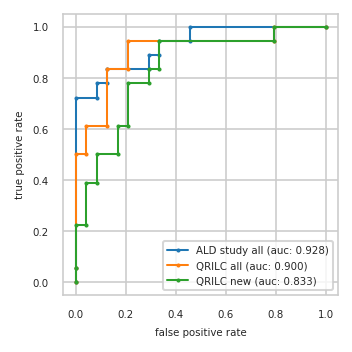

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.722     0.000 0.500     0.000 0.222
3          0.083 0.722     0.042 0.500     0.042 0.222
4          0.083 0.778     0.042 0.611     0.042 0.389
5          0.125 0.778     0.125 0.611     0.083 0.389
6          0.125 0.833     0.125 0.833     0.083 0.500
7          0.292 0.833     0.208 0.833     0.167 0.500
8          0.292 0.889     0.208 0.944     0.167 0.611
9          0.333 0.889     0.792 0.944     0.208 0.611
10         0.333 0.944     0.792 1.000     0.208 0.778
11         0.458 0.944     1.000 1.000     0.292 0.778
12         0.458 1.000       NaN   NaN     0.292 0.833
13         1.000 1.000       NaN   NaN     0.333 0.833
14           NaN   NaN       NaN   NaN     0.333 0.944
15           NaN   NaN       NaN   NaN     0.792 0.944
16           NaN   NaN       NaN   NaN     0.792 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,D6R956;P09936
1,Q15848,Q8NBI6,None
2,P09960;P09960-4,D6RGG3;Q99715,None
3,P61981,Q9Y2T3;Q9Y2T3-3,None
4,P14174,P61981,None
5,P04075,P14174,None
6,P00338;P00338-3,P04075,None
7,Q9Y2T3;Q9Y2T3-3,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None
8,P08294,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


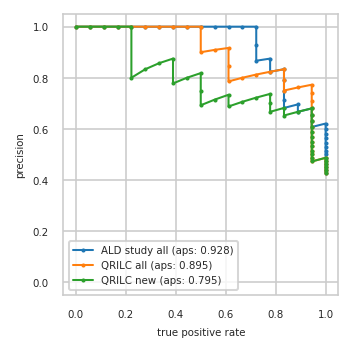

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.472 0.944     0.472 0.944
7          0.514 1.000     0.486 0.944     0.486 0.944
8          0.529 1.000     0.500 0.944     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.621 1.000     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.607 0.944
15         0.630 0.944     0.630 0.944     0.630 0.944
16         0.654 0.944     0.654 0.944     0.654 0.944
17         0.680 0.944     0.680 0.944     0.680 0.944
18         0.667 0.889     0.708 0.944     0.667 0.889
19         0.696 0.889     0.739 0.944     0.652 0.833
20         0.682 0.833     0.773 0.944     0.682 0.833
21         0.714 0.833     0.762 0.889     0.667 0.778
22         0.750 0.833     0.750 0.833     0.700 0.778
23         0.789 0.833     0.789 0.833     0.737 0.778
24         0.833 0.833     0.833 0.833     0.722 0.722
25         0.824 0.778     0.824 0.778     0.706 0.667
26         0.875 0.778     0.812 0.722     0.688 0.611
27         0.867 0.722     0.800 0.667     0.733 0.611
28         0.929 0.722     0.786 0.611     0.714 0.556
29         1.000 0.722     0.846 0.611     0.692 0.500
30         1.000 0.667     0.917 0.611     0.750 0.500
31         1.000 0.611     0.909 0.556     0.818 0.500
32         1.000 0.556     0.900 0.500     0.800 0.444
33         1.000 0.500     1.000 0.500     0.778 0.389
34         1.000 0.444     1.000 0.444     0.875 0.389
35         1.000 0.389     1.000 0.389     0.857 0.333
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     1.000 0.222
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


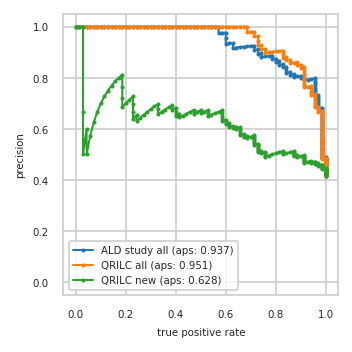

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


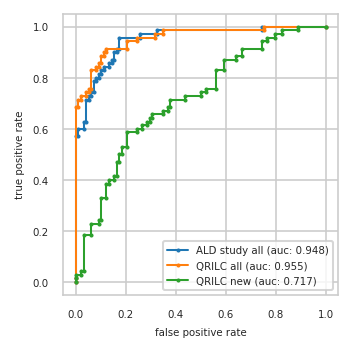

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}